In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import matplotlib.patches as mpatches
import umap
from importlib import reload
from scipy import stats
from scipy.stats import ranksums
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget
import sys

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-03-14 09:42:48.815094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 09:42:48.926240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-14 09:42:48.926266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 09:42:48.952683: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-14 09:42:50.2686

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/validation/../utils.py'>

In [2]:
# load cluster assignments
cdf = pd.read_csv("../clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [4]:
"""
0               CD4_TotalSeqB      CD4 T cell
1             CD11b_TotalSeqB    CD11b Macrophage, Monocyte, DC
2             CD11c_TotalSeqB    CD11c Macrophage, DC
3              CD19_TotalSeqB     CD19 B cell
4             F4-80_TotalSeqB    F4-80 Macrophage
5             CD161_TotalSeqB    CD161 
6               CD3_TotalSeqB      CD3 T cell
7  Mac-2_Galectin-3_TotalSeqB    Mac-2 Macrophage (subtype)
"""

'\n0               CD4_TotalSeqB      CD4 T cell\n1             CD11b_TotalSeqB    CD11b Macrophage, Monocyte, DC\n2             CD11c_TotalSeqB    CD11c Macrophage, DC\n3              CD19_TotalSeqB     CD19 B cell\n4             F4-80_TotalSeqB    F4-80 Macrophage\n5             CD161_TotalSeqB    CD161 \n6               CD3_TotalSeqB      CD3 T cell\n7  Mac-2_Galectin-3_TotalSeqB    Mac-2 Macrophage (subtype)\n'

In [5]:
antiPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/antibodies/"

keys = ['ND', 'HFD8', 'HFD14']

res = []

for k in keys:
    fPath = f"{antiPath}{k}.csv"
    af = pd.read_csv(fPath)
    af['key'] = k
    res.append(af)
    
    
anti = pd.concat(res, ignore_index=True)
print(anti['key'].value_counts())
anti = anti.rename(columns={'Unnamed: 0': 'cellId'})

print()
print(anti.columns)
print()

anti.head()

HFD14    7146
HFD8     6558
ND       1414
Name: key, dtype: int64

Index(['cellId', 'CD4_TotalSeqB', 'CD11b_TotalSeqB', 'CD11c_TotalSeqB',
       'CD19_TotalSeqB', 'F4-80_TotalSeqB', 'CD161_TotalSeqB', 'CD3_TotalSeqB',
       'Mac-2_Galectin-3_TotalSeqB', 'key'],
      dtype='object')



,cellId,CD4_TotalSeqB,CD11b_TotalSeqB,CD11c_TotalSeqB,CD19_TotalSeqB,F4-80_TotalSeqB,CD161_TotalSeqB,CD3_TotalSeqB,Mac-2_Galectin-3_TotalSeqB,key
0,AAACGAACAGCAGTAG-1,18.0,19.0,0.0,37.0,25.0,0.0,17.0,32.0,ND
1,AAAGAACGTCTACAGT-1,10.0,176.0,0.0,25.0,57.0,0.0,14.0,16.0,ND
2,AAAGAACTCCTCGCAT-1,55.0,1593.0,0.0,95.0,612.0,0.0,69.0,114.0,ND
3,AAAGGGCGTTAGGGTG-1,52.0,1020.0,0.0,85.0,54.0,0.0,55.0,72.0,ND
4,AAAGGTAAGACGTCCC-1,141.0,1978.0,0.0,493.0,316.0,0.0,219.0,226.0,ND


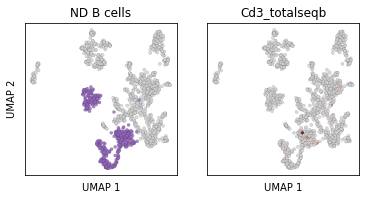

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = "w"
pltSize = 3
ncolor = 5
lb = 2
ub = 10000
keys = ['ND']
query = ['CD3_TotalSeqB']
ctype = 'B cells'
color = "C4"


res = []

for key in keys:
    data = adata[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get the antibodies
    df['cellId'] = df.index    
    af = anti[anti['key'] == key]
    
    antibodies = list(set(list(af.columns) + query))
    
    df = pd.merge(df, af, 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    df = df[antibodies]
    
        
    # get all clusters for the cell type
    cellTypes = cid[key]
    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
    
      # set up th plot
    nPlots = len(query) + 1

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize
        
    fig, axs = plt.subplots(1, len(query)+1, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()

    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
    
    mask = clusterIds.isin(cellTypeIds)
    order = np.argsort(mask)
    c = np.where(mask, color, 'lightgrey')
    y_true = np.where(mask, 1, 0)

    axs[0].scatter(embedding[: , 0][order], 
                   embedding[:, 1][order], 
                   c=c[order],
                   s=10,
                   edgecolor="k",
                   lw=0.1,
                   alpha=0.8)

    axs[0].set_title(f"{key} {ctype}")
    axs[0].set_xlabel("UMAP 1")
    axs[0].set_ylabel("UMAP 2")
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    
    # plot the expression of each validation gene
    for i, g in enumerate(query):
        plotNum = i + 1
                
        bins = np.linspace(lb, ub, ncolor+1)
        colornames = ut.ncolor(ncolor, 'Reds')
        colornames[0] = 'lightgrey'
        c = pd.cut(df[g], bins=bins, labels=colornames).astype(str)
        c = c.fillna("lightgrey").to_numpy()
        c = np.where(c == 'nan', "lightgrey", c)

        order = np.argsort(mask)
        y_pred = np.where(mask, 1, 0)

        axs[plotNum].scatter(embedding[: , 0][order] , 
                             embedding[:, 1][order] , 
                             c=c[order],
                             cmap='viridis',
                             s=10,
                             edgecolor="k",
                             lw=0.1,
                             alpha=0.8)
        
        axs[plotNum].set_title(str(g).lower().capitalize())
        axs[plotNum].set_xlabel("UMAP 1")
        axs[plotNum].set_yticks([])
        axs[plotNum].set_xticks([])

#         """Compute jaccard sim with the label """

#         row = {
#             'Key' : key,
#             'cellType' : ctype,
#             'Gene' : g,
#             # 'jaccrd' : metrics.jaccard_score(y_true, y_pred),
#             'accuracy' : metrics.accuracy_score(y_true, y_pred),
#             'precision' : metrics.precision_score(y_true, y_pred),
#         }
#         print(row)
#         res.append(row)

#     # plt.tight_layout()
#     plt.subplots_adjust(wspace=0.05)

# res = pd.DataFrame(res)
# print('done')

In [7]:
cdf['cellType'].value_counts()

Macrophages        20
Dendritic cells    12
Monocytes          10
T cells             8
B cells             6
Stromal cells       4
NK cells            3
Name: cellType, dtype: int64

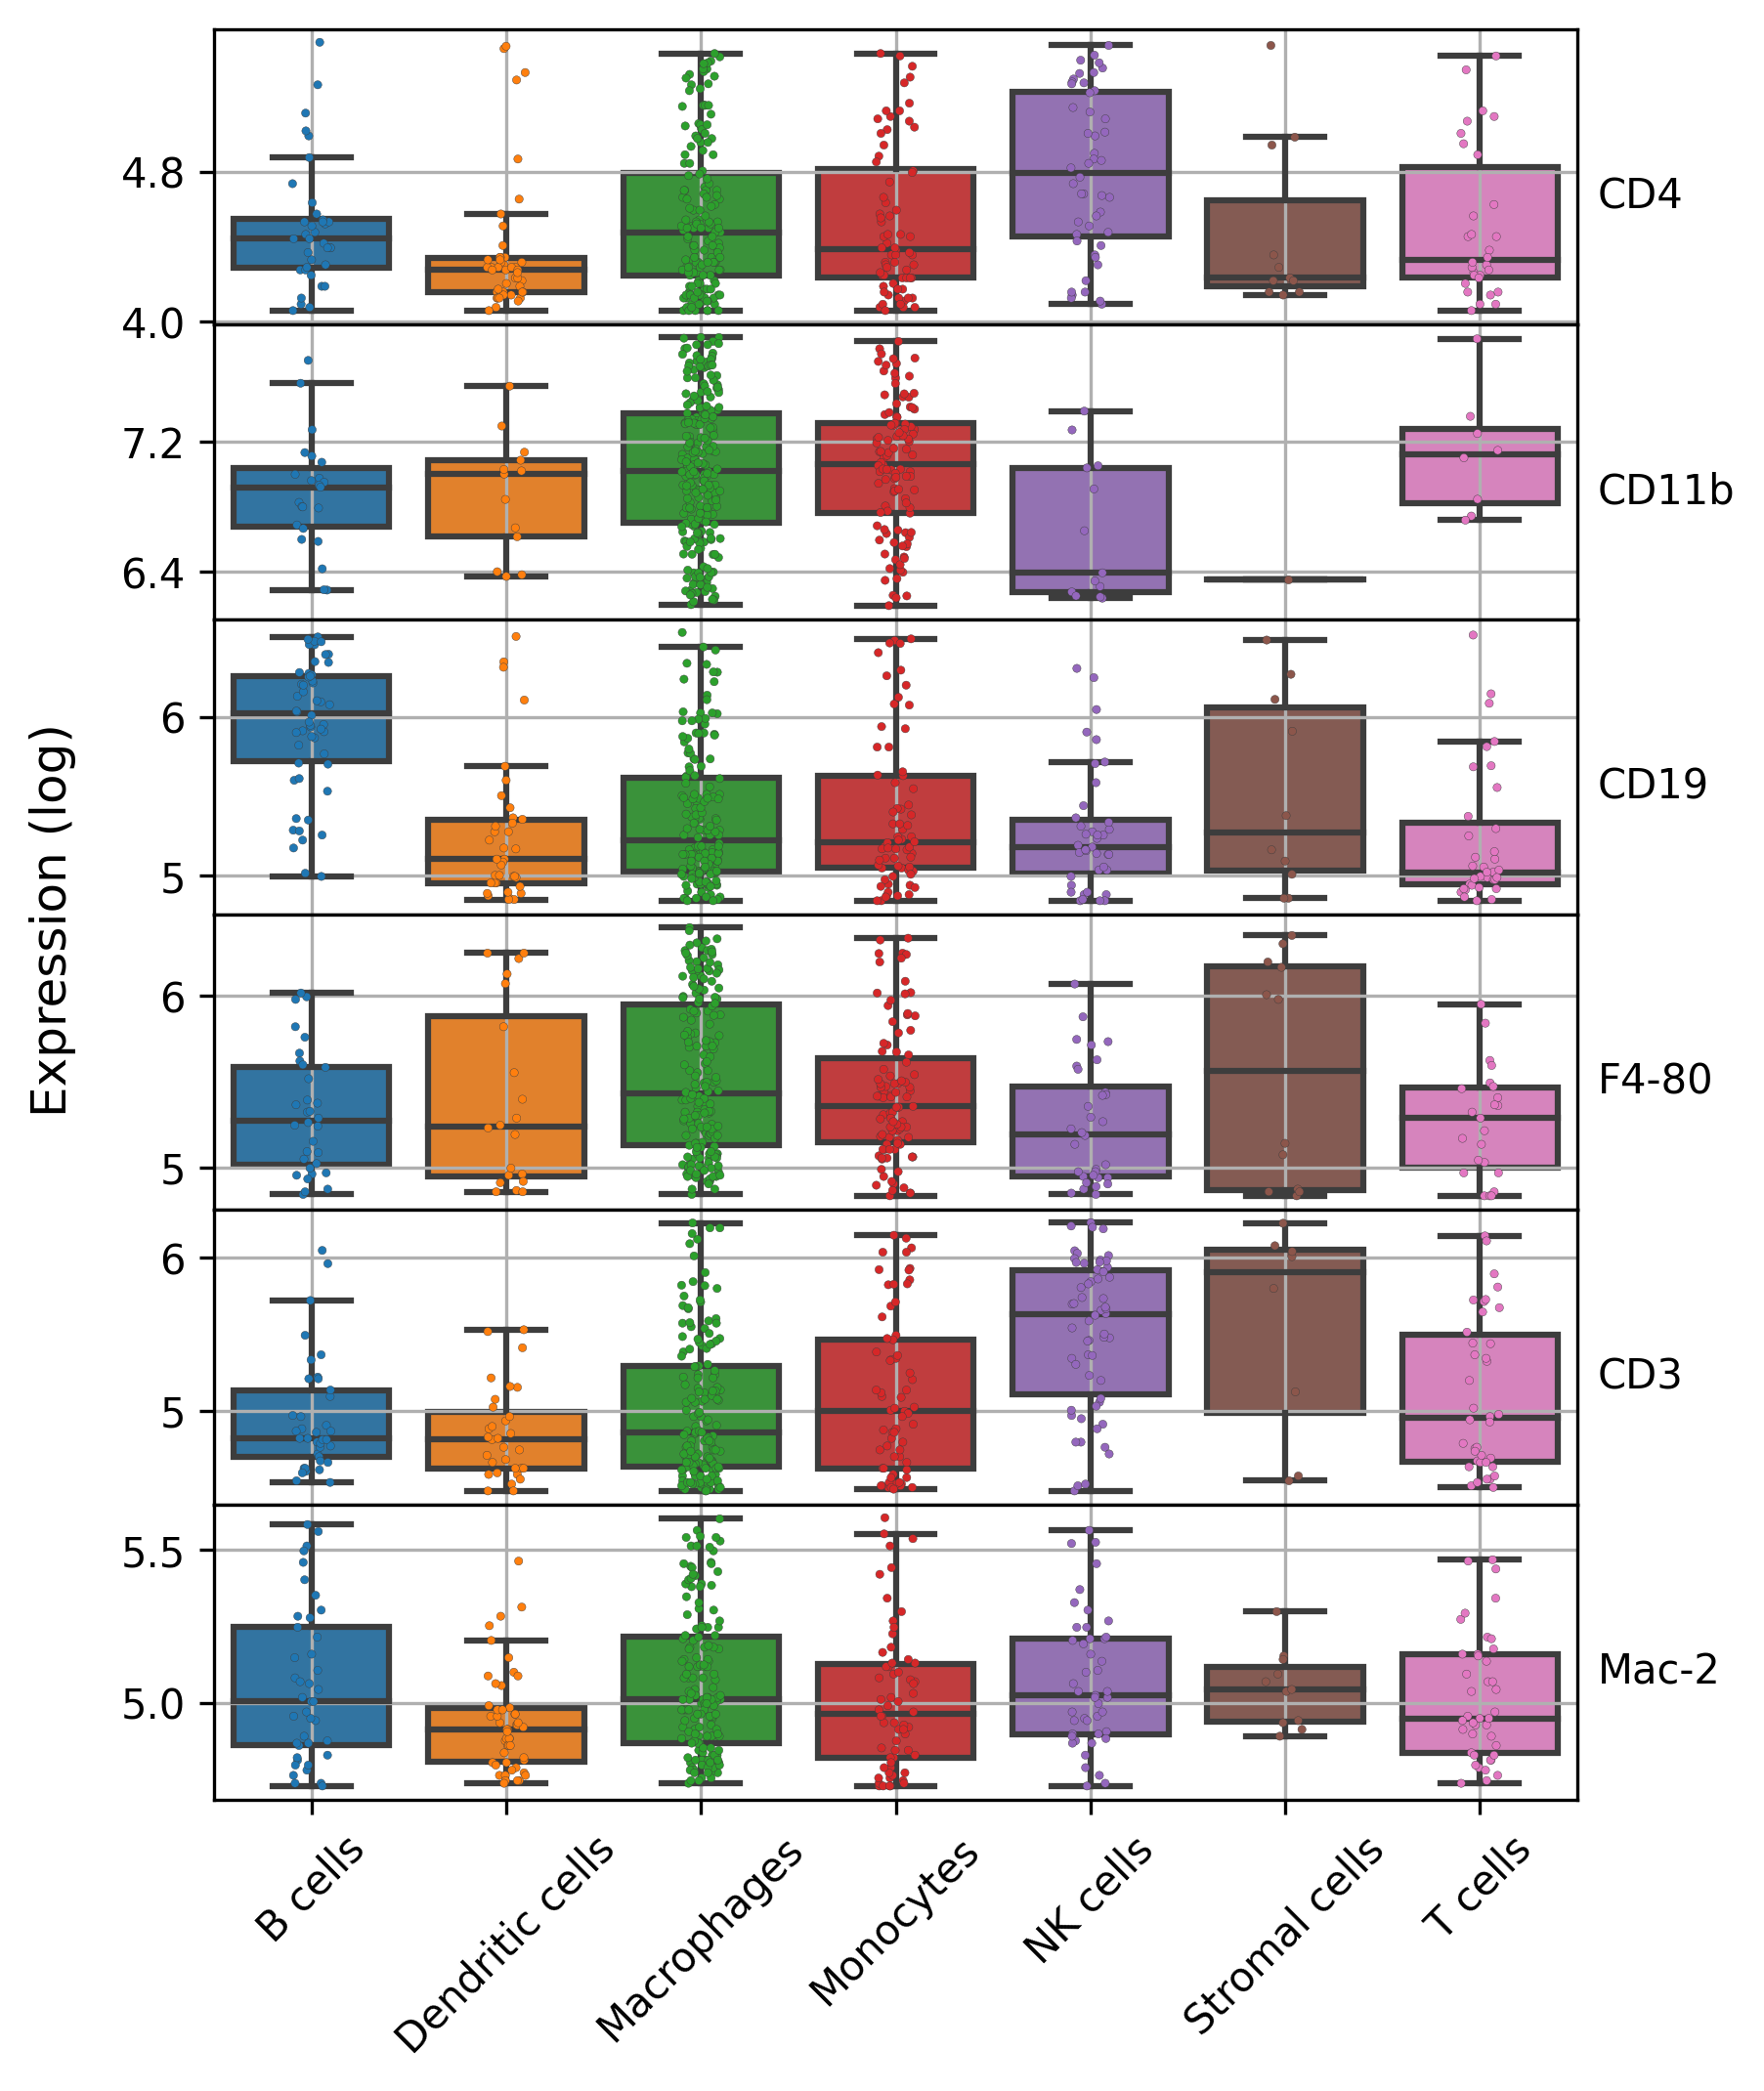

In [8]:
mapper = {
    
              'CD4_TotalSeqB' : ['T cells'],
            'CD11b_TotalSeqB' : ['Macrophages', 'Dendritic cells', 'Monocytes'],
            'CD11c_TotalSeqB' : ['Macrophages', 'Dendritic cells'],
             'CD19_TotalSeqB' : ['B cells'],
            'F4-80_TotalSeqB' : ['Macrophages'],
            # 'CD161_TotalSeqB' : [] 
              'CD3_TotalSeqB' : ['T cells'],
 'Mac-2_Galectin-3_TotalSeqB' : ['Macrophages'],
}


antinames = {
              'CD4_TotalSeqB' : 'CD4',
            'CD11b_TotalSeqB' : 'CD11b',
            # 'CD11c_TotalSeqB' : 'CD11c',
             'CD19_TotalSeqB' : 'CD19',
            'F4-80_TotalSeqB' : 'F4-80',
            # 'CD161_TotalSeqB' : 'CD161',
              'CD3_TotalSeqB' : 'CD3',
 'Mac-2_Galectin-3_TotalSeqB' : 'Mac-2',
}


keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 8
lq = 50
uq = 90


for key in keys:
    data = adata[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    # get the clusters
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get the cell types
    cf = cdf[cdf['key'] == key]
    typemapper = dict(zip(cf['clusterId'], cf['cellType']))
    typeLabels = [typemapper[i] for i in clusterIds]
    
    # get antibody expression
    df['cellId'] = df.index    
    af = anti[anti['key'] == key]
    
    antibodies = af.columns
    df = pd.merge(df, af, 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    df = df[antibodies].fillna(0)
    df['cellType'] = typeLabels
    df['clusterId'] = clusterIds.to_list()
    
    # drop cluster 2
    df = df[df['clusterId'] != 2]
    df = df[df['clusterId'] != 4]
    
    fig, axs = plt.subplots(6, 1, sharex=True)
    axs = axs.ravel()
    
    for i, protien in enumerate(antinames.keys()):
        
        lowerBound = np.percentile(df[protien], lq)
        upperBound = np.percentile(df[protien], uq)
        mask = (df[protien] > lowerBound) & (df[protien] < upperBound)
        
        bf = df[mask].reset_index()
        bf[protien] = np.log(bf[protien])
        
        bf = bf.sort_values(by='cellType')
        
        
        # axs[i].hist(df[protien], bins=30, edgecolor="k")
        # axs[i].set_yscale("log")
        # axs[i].set_xlabel(f"{protien} Expression")
        # axs[i].set_ylabel("n Cells")
        # axs[i].axvline(x=lowerBound, zorder=2, c='r')
        # axs[i].axvline(x=upperBound, zorder=2, c='r')
        
        sns.boxplot(data=bf, 
                       x="cellType", 
                       y=protien,
                       ax=axs[i],
                       # inner=None,
                       showfliers=False)
        
        sns.stripplot(data=bf,
                      x="cellType", 
                      y=protien,
                      ax=axs[i],
                      size=2,
                      linewidth=0.1)
        
        axs[i].set_xlabel("")
        axs[i].set_ylabel(antinames[protien],
                          rotation=0, 
                          labelpad=5,
                          horizontalalignment='left')
        axs[i].yaxis.set_label_position("right")
        axs[i].yaxis.set_major_locator(plt.MaxNLocator(2))
        axs[i].grid()
    
    plt.xticks(rotation=45)
    plt.subplots_adjust(wspace=0, hspace=0)
    _ = fig.supylabel("Expression (log)", x=.02)
    
#     plt.show()
    break


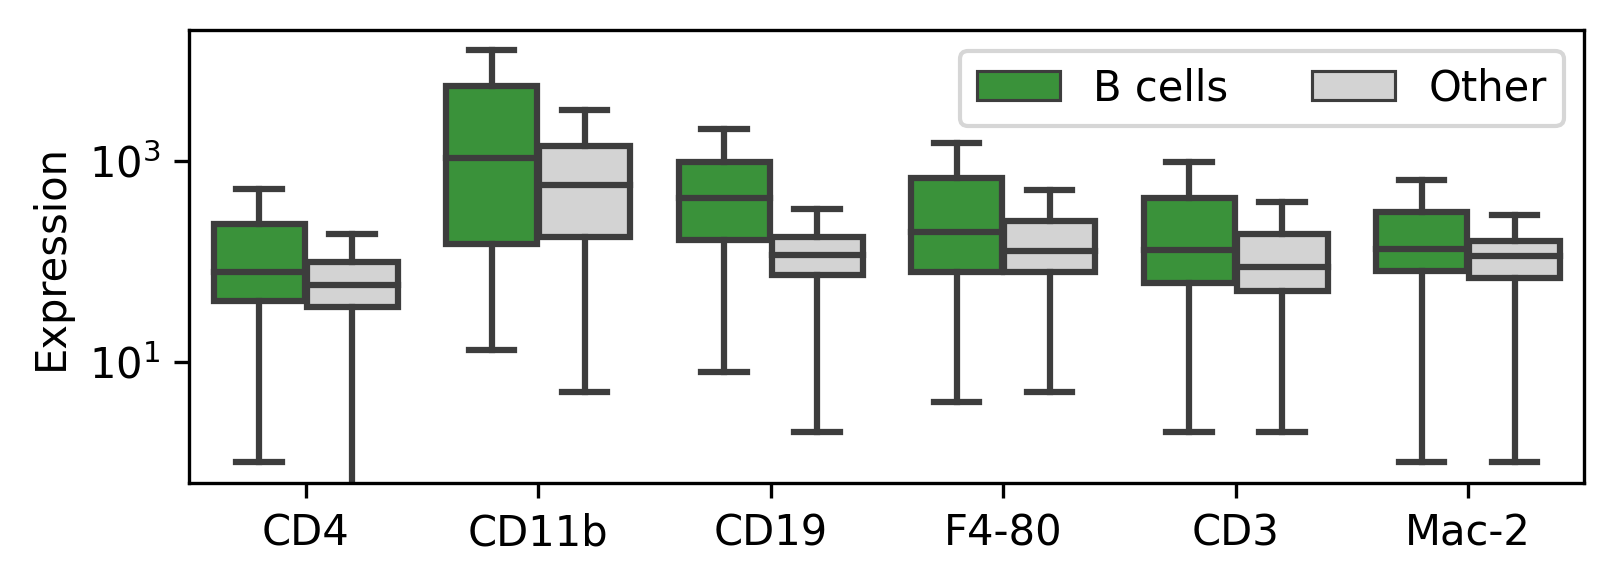

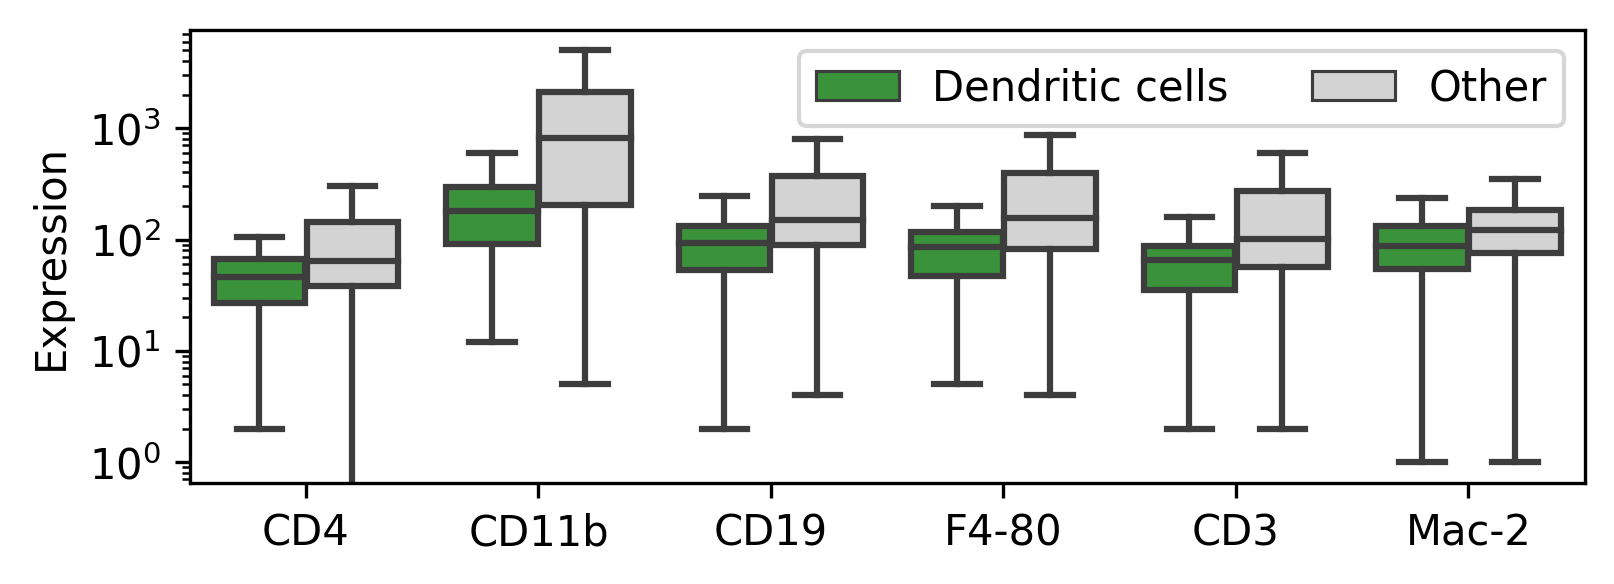

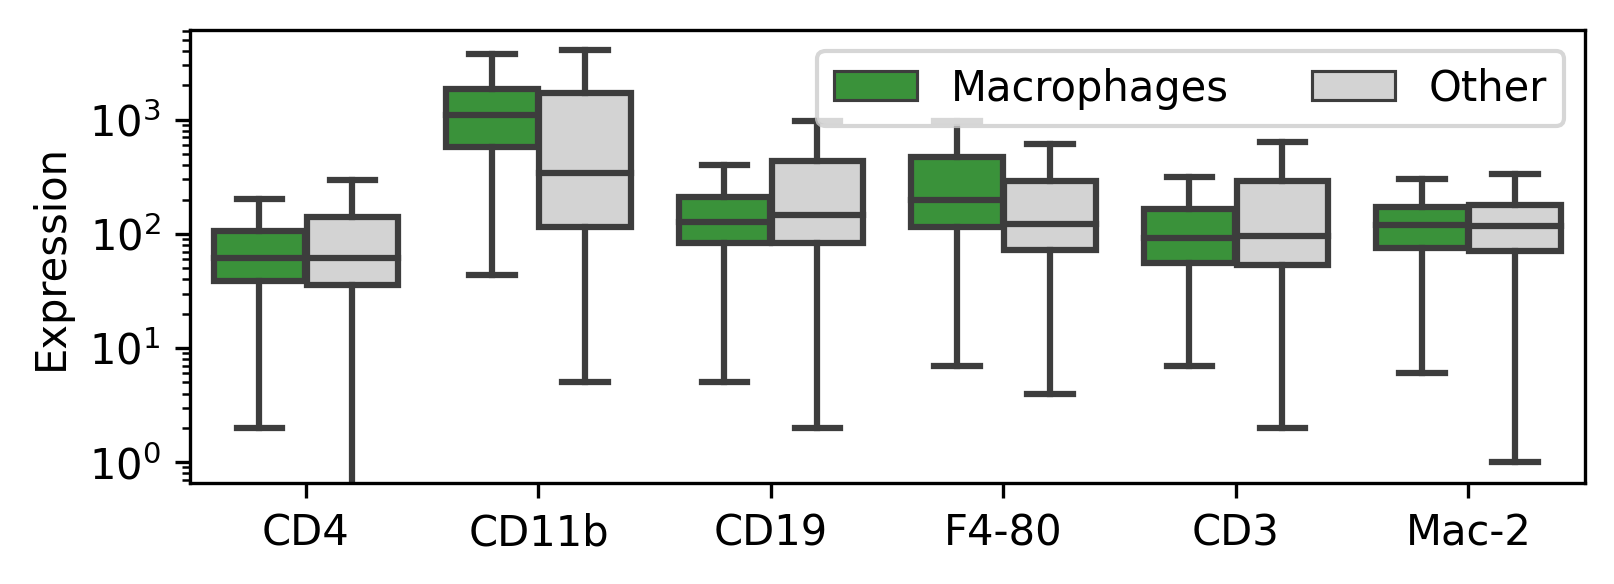

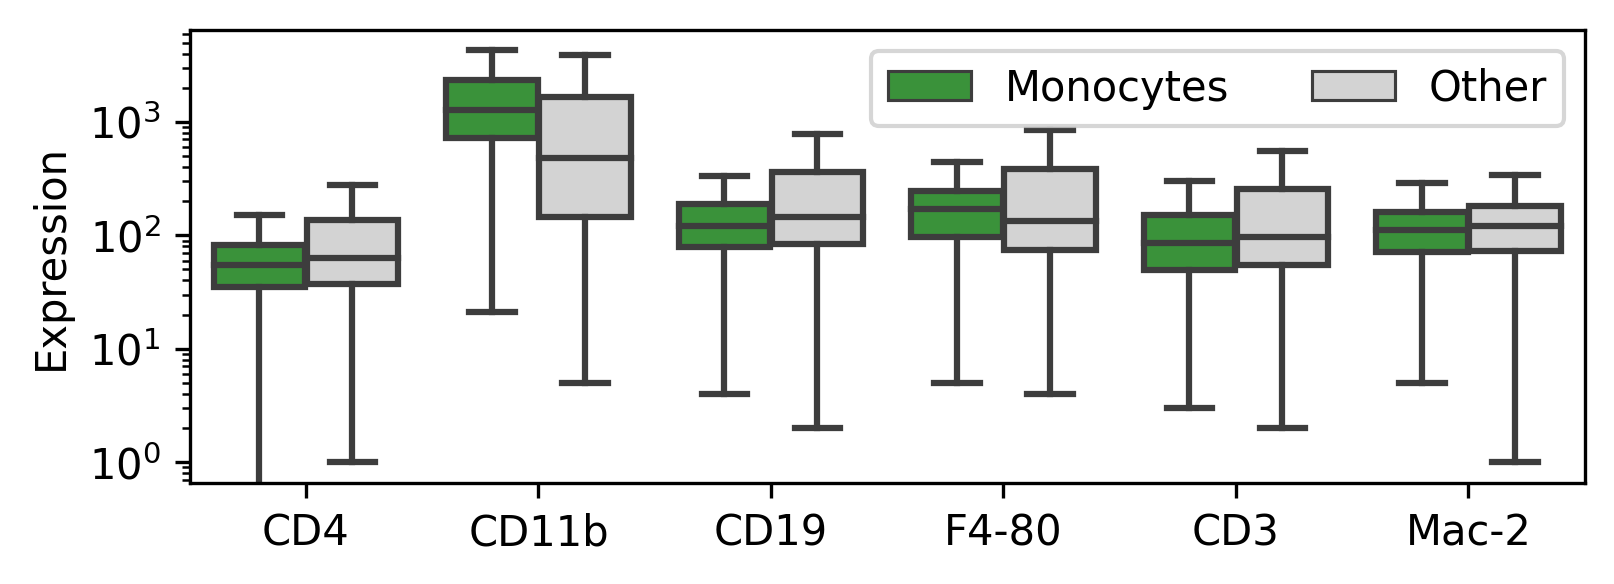

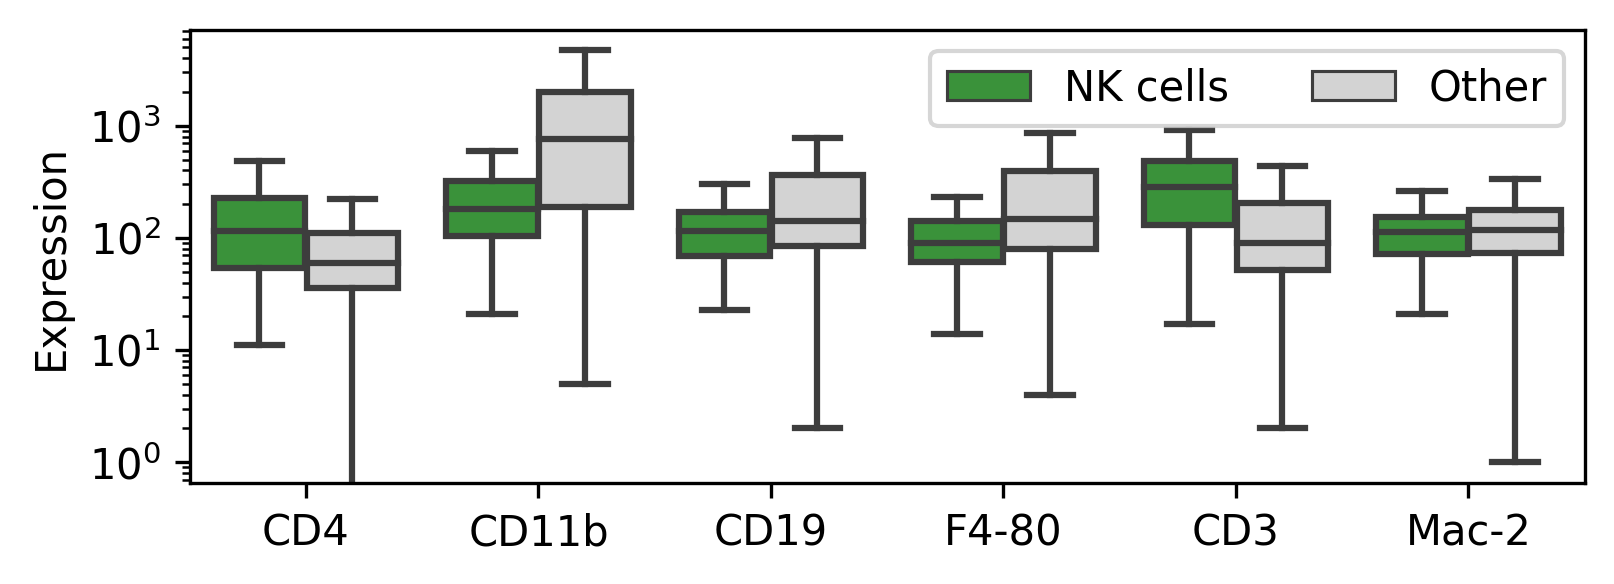

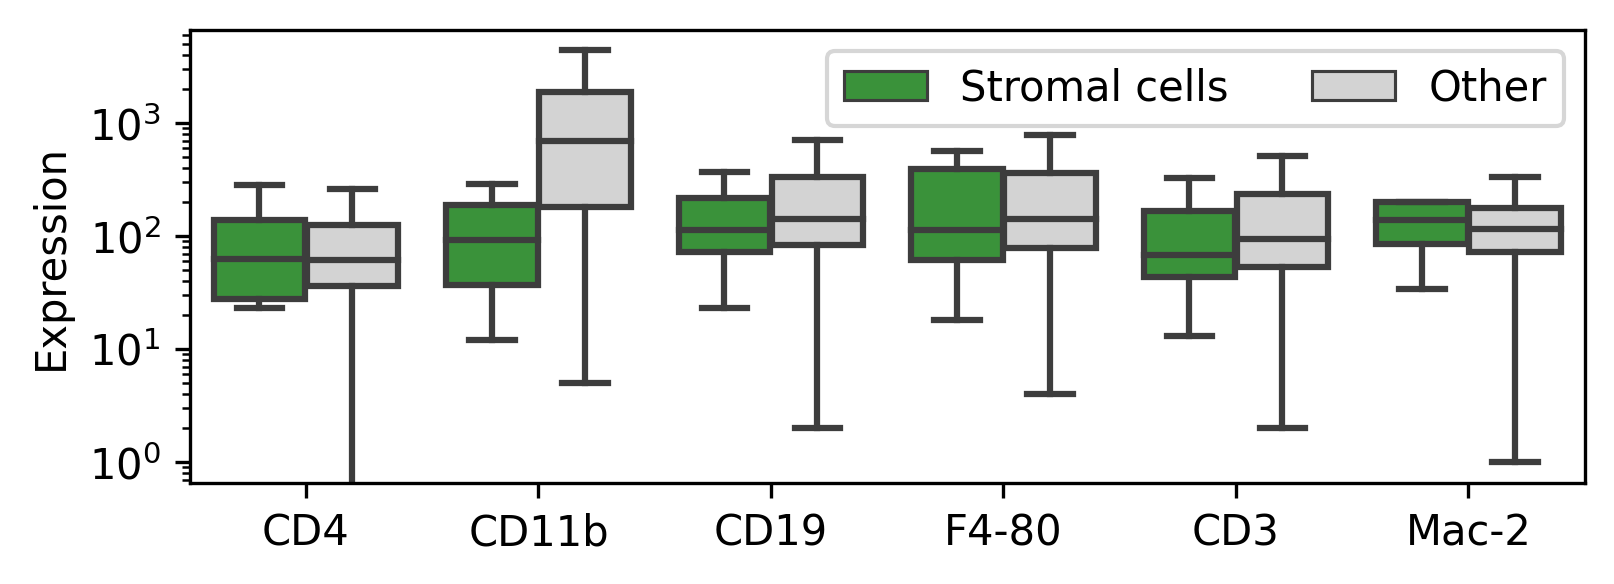

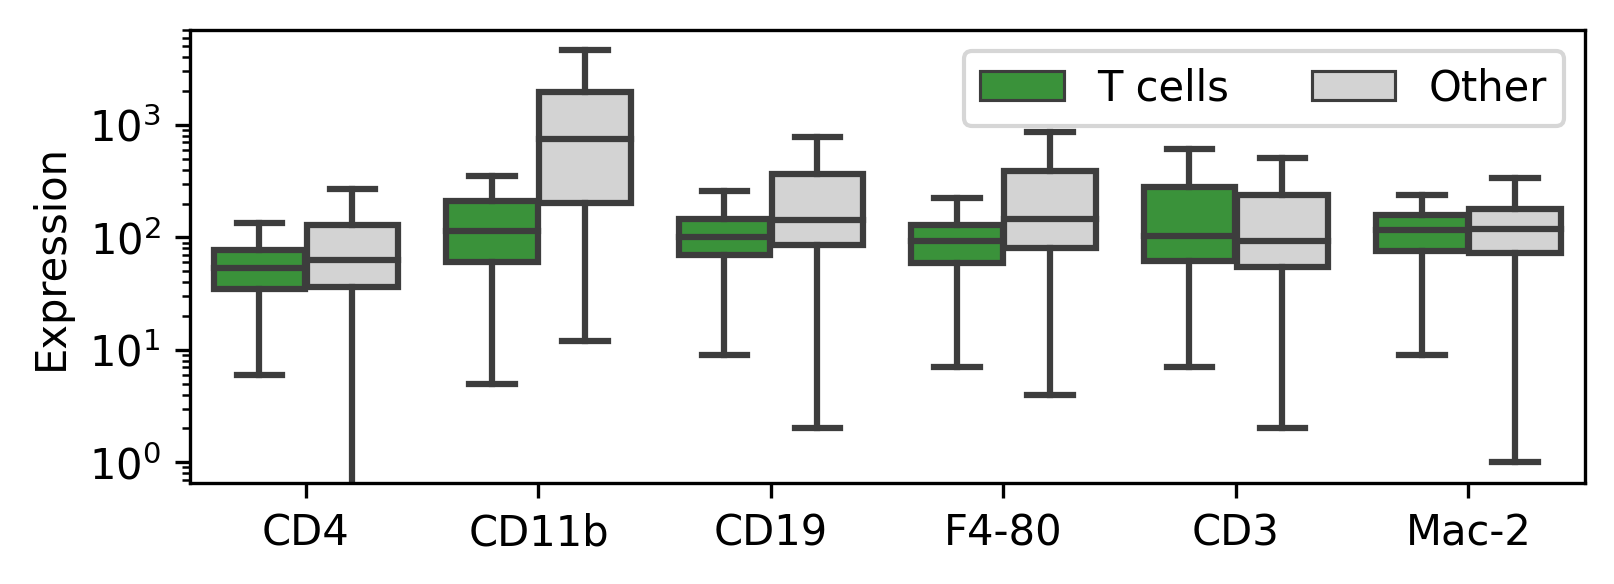

In [9]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 2

for key in keys:
    data = adata[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    # get the clusters
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get the cell types
    cf = cdf[cdf['key'] == key]
    typemapper = dict(zip(cf['clusterId'], cf['cellType']))
    typeLabels = [typemapper[i] for i in clusterIds]
    
    # get antibody expression
    df['cellId'] = df.index    
    af = anti[anti['key'] == key]
    
    antibodies = af.columns
    df = pd.merge(df, af, 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    df = df[antibodies].fillna(0)
    df['cellType'] = typeLabels
    df['clusterId'] = clusterIds.to_list()
    
    # drop cluster 2
    # df = df[df['clusterId'] != 2]
    # df = df[df['clusterId'] != 4]
    
    
    df = df.sort_values(by='cellType')
    
    for i, ctype in enumerate(df['cellType'].unique()):
        
        dfm = pd.melt(df, id_vars=['cellId', 'clusterId', 'cellType'], 
                      value_vars=list(antinames.keys()),
                      var_name='Protien',
                      value_name='Expression')
        
        mask = dfm['cellType'] == ctype
        groupLabel = np.where(mask, ctype, 'Other')
        
        sns.boxplot(data=dfm, 
                    x='Protien',
                    y='Expression',
                    hue_order=[ctype, "Other"],
                    hue=groupLabel,
                    palette=['C2', 'lightgrey'],
                    showfliers=False)
        
        plt.yscale('log')
        plt.xlabel("")
        plt.legend(ncol=2, 
                   loc='upper right')
        locs, labels = plt.xticks()
        _ = plt.xticks(locs, list(antinames.values()))
        plt.show()

    break
    


In [24]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5.5, 7

res = []

for key in keys:
    data = adata[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    # get the clusters
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get the cell types
    cf = cdf[cdf['key'] == key]
    typemapper = dict(zip(cf['clusterId'], cf['cellType']))
    typeLabels = [typemapper[i] for i in clusterIds]
    
    # get antibody expression
    df['cellId'] = df.index    
    af = anti[anti['key'] == key]
    
    antibodies = af.columns
    df = pd.merge(df, af, 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    df = df[antibodies].fillna(0)
    df['cellType'] = typeLabels
    df['clusterId'] = clusterIds.to_list()
    
    # drop cluster 2
    df = df[df['clusterId'] != 2]
    df = df[df['clusterId'] != 4]
    
    for ctype in df['cellType'].unique():
        ctypeMask = df['cellType'] == ctype
        for a in antinames.keys():
            
            A = df[ctypeMask][a]
            B = df[~ctypeMask][a]
            
            score, pval = ranksums(A, B, alternative='greater')
            lfc = np.log2(A.mean()) - np.log2(B.mean())
            
            row = {
                "key" : key,
                "cell type" : ctype,
                "score" : score,
                "pval" : pval,
                "protien" : a.split("_")[0],
                'log2foldchange' : lfc
            }
            
            res.append(row)

    
    # print(df.head())
    # break
    
res = pd.DataFrame(res)
res

,key,cell type,score,pval,protien,log2foldchange
0,ND,Macrophages,2.343610,9.549059e-03,CD4,0.318569
1,ND,Macrophages,14.447249,1.304508e-47,CD11b,0.962896
2,ND,Macrophages,-0.245106,5.968130e-01,CD19,-0.261059
3,ND,Macrophages,10.432798,8.781926e-26,F4-80,0.995666
4,ND,Macrophages,0.621419,2.671621e-01,CD3,-0.051211
...,...,...,...,...,...,...
121,HFD14,B cells,-11.769616,1.000000e+00,CD11b,-1.681498
122,HFD14,B cells,13.248575,2.299256e-40,CD19,0.699069
123,HFD14,B cells,-9.441314,1.000000e+00,F4-80,-1.447510
124,HFD14,B cells,0.117715,4.531468e-01,CD3,-0.409037


In [31]:
alpha = 0.05
n = 2
lfc = 0.5

ntests = len(res) / 3
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = res[res['pval'] < alphaHat]
sig = sig[sig['log2foldchange'] > lfc]

sig = sig[sig['cell type'] != 'Stromal cells']


print(sig.round(3).to_latex())

alpha=0.05 ntests=42.0 0.0012205234686031297
\begin{tabular}{lllrrlr}
\toprule
{} &    key &    cell type &   score &  pval & protien &  log2foldchange \\
\midrule
1   &     ND &  Macrophages &  14.447 &   0.0 &   CD11b &           0.963 \\
3   &     ND &  Macrophages &  10.433 &   0.0 &   F4-80 &           0.996 \\
7   &     ND &    Monocytes &  10.447 &   0.0 &   CD11b &           1.200 \\
14  &     ND &      B cells &  14.057 &   0.0 &    CD19 &           1.977 \\
24  &     ND &     NK cells &   6.068 &   0.0 &     CD4 &           0.618 \\
28  &     ND &     NK cells &   7.876 &   0.0 &     CD3 &           0.928 \\
48  &   HFD8 &  Macrophages &   6.805 &   0.0 &     CD4 &           0.520 \\
49  &   HFD8 &  Macrophages &  32.212 &   0.0 &   CD11b &           1.452 \\
51  &   HFD8 &  Macrophages &  29.051 &   0.0 &   F4-80 &           1.252 \\
53  &   HFD8 &  Macrophages &  13.094 &   0.0 &   Mac-2 &           0.619 \\
76  &   HFD8 &      T cells &  14.461 &   0.0 &     CD3 &         

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5.5, 7

results = []

for key in keys:
    data = adata[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    # get the clusters
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get the cell types
    cf = cdf[cdf['key'] == key]
    typemapper = dict(zip(cf['clusterId'], cf['cellType']))
    typeLabels = [typemapper[i] for i in clusterIds]
    
    # get antibody expression
    df['cellId'] = df.index    
    af = anti[anti['key'] == key]
    
    antibodies = af.columns
    df = pd.merge(df, af, 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    df = df[antibodies].fillna(0)
    df['cellType'] = typeLabels
    df['clusterId'] = clusterIds.to_list()
    
    # drop cluster 2
    df = df[df['clusterId'] != 2]
    df = df[df['clusterId'] != 4]
    
    for ctype in df['cellType'].unique():
        ctypeMask = df['cellType'] == ctype
        for a in antinames.keys():
            
            A = df[ctypeMask][a]
            B = df[~ctypeMask][a]
            lfc = np.log2(A.mean()) - np.log2(B.mean())
            
            # print(f"{ctype} {a} {A.mean():.3f} {B.mean():.3f} {lfc:.3f}")
            
            
            row = {
                'cellType' : ctype,
                'Protien' : a,
                'LFC' : lfc,
            }
            
            results.append(row)
    
    break
    
results = pd.DataFrame(results)
t = pd.pivot_table(results, 
                   index='cellType', 
                   columns='Protien', 
                   values='LFC')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 4

sns.heatmap(t, 
            cmap='RdYlGn', 
            linewidth=0.5,
            linecolor='k',
            annot=True,
            cbar_kws={'label' : 'Fold Change (log2)'})

ax = plt.gca()
locs, labels = plt.xticks()
plt.ylabel("")
plt.xlabel("")

labels = [antinames[i] for i in t.columns]
_ = plt.xticks(locs, labels, rotation=0)